<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Modelling heterogeneous distributions with an
Uncountable Mixture of Asymmetric Laplacians (UMAL) </h2></div>

Code is made available under the [Apache Version 2.0 License](https://www.apache.org/licenses/LICENSE-2.0). 

> Copyright 2019
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>    http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.


This source code corresponds to an official UMAL implementation of the following paper's contribution: 

[***Axel Brando, Jose A. Rodriguez-Serrano, Jordi Vitria, Alberto Rubio. "Modelling heterogeneous distributions with an Uncountable Mixture of Asymmetric Laplacians." Advances in Neural Information Processing Systems. 2019.***](LINK)

Please, to use this material and the code follow the instructions explained in the main repository [LINK](LINK).

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:white;font-family:Verdana,sans-serif;font-size:16px;">
<h3>Room price forecasting problem - YVC</h3></div>

Price forecasting per night of houses / rooms offered on Airbnb for the city of Vancouver by using public information downloaded from:

Murray Cox. Inside airbnb: adding data to the debate. Inside Airbnb [Internet].[cited 16 May
2019]. Available: http://insideairbnb.com, 2019.

Price prediction is based on informative features such as neighbourhood, number of beds and other characteristics associated to the spaces.

Using TensorFlow backend.


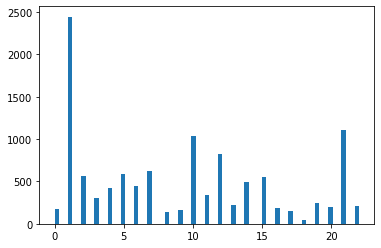

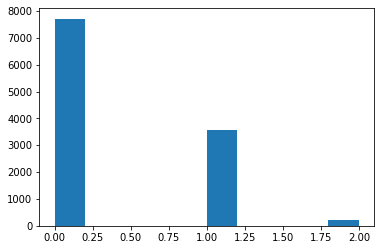

{'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}
(11497, 106) (9197, 61) (1150, 61) (1150, 61)
(11497, 106) (9188, 61) (1146, 61) (1150, 61)


In [1]:
#If you are using GPU uncomment the following lines starting with '##'

## import os
## os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
## os.environ["CUDA_VISIBLE_DEVICES"]='1'

import tensorflow as tf
config = tf.ConfigProto()
## config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

from keras import backend as K

K.set_session(sess)
general_type = 'float64' #or 'float32'
K.set_floatx(general_type)

import keras
from keras.layers.core import Dense
from keras.layers import Activation

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import numpy as np
import pandas as pd

from umal import build_UMAL, elu_modif, calculate_distribution, log_sum_exp, np_log_sum_exp

# You need to generate this pickle file collecting the last time each apartment 
#  appeared within the months available from April 2018 to March 2019 in Vancouver.
listing = pd.read_pickle("data/YVC_listings_2018_04_2019_03.pkl")

nh = 'neighbourhood_cleansed'
onehot = {i:e for e,i in enumerate(np.unique(listing[nh].values))}
lst = []
for i in listing[nh].values:
    lst += [onehot[i]]

plt.figure()
plt.hist(lst,bins=69)
plt.show()

listing.fillna(-np.inf, inplace=True)

# extract the 'prices' from the table
price = listing['price']

prices = []

# the values are stored as '$7,000' instead of 7000.
# data cleaning to make the values into floats
for element in price:
    element = float(element[1:].replace(',',''))
    prices.append(element)
listing['price'] = prices

oh = {i:e for e,i in enumerate(np.unique(listing['room_type'].values))}
plt.figure()
plt.hist([oh[i] for i in listing['room_type']])
plt.show()
print(oh)

s_pt = pd.Series(list(listing['property_type']))
s_rt = pd.Series(list(listing['room_type']))
# Obtain the onehot encoding of the neighbourhood
s_n_1 = pd.Series(list(listing['neighbourhood_cleansed']))
s_n_2 = pd.Series(list(listing['neighbourhood_group_cleansed']))
        
# Attributes concatenation
X = np.concatenate((listing['longitude'].values.reshape(-1,1),
                    listing['latitude'].values.reshape(-1,1),
                    pd.get_dummies(s_rt).values,
                    listing['bathrooms'].values.reshape(-1,1),
                    listing['accommodates'].values.reshape(-1,1),
                    pd.get_dummies(s_pt).values,
                    pd.get_dummies(s_n_1).values,
                    pd.get_dummies(s_n_2).values),
                   axis=1)

y = listing['price'].values.reshape(-1,1)

#Due to it is always the same city, we can normalize by min max the locations
X[:,:2] = (X[:,:2]-X[:,:2].min(axis=0))
X[:,:2] = X[:,:2]/X[:,:2].max(axis=0)

def divide(x,tanpercent=10,seed=42):
    np.random.seed(seed)
    pos = np.arange(x.shape[0])
    np.random.shuffle(pos)
    
    tmp_x = x[pos]
    
    return tmp_x[:int(80*x.shape[0]/100)], tmp_x[int(80*x.shape[0]/100):int(90*x.shape[0]/100)], tmp_x[int(90*x.shape[0]/100):]

x_train, x_valid, x_test = divide(X)
y_train, y_valid, y_test = divide(y)

assert x_train.shape[0]+x_valid.shape[0]+x_test.shape[0] == X.shape[0]
assert y_train.shape[0]+y_valid.shape[0]+y_test.shape[0] == X.shape[0]

print(listing.shape,x_train.shape,x_valid.shape,x_test.shape)

fltr = lambda x,y: (x[np.isneginf(x).sum(axis=1)==0],y[np.isneginf(x).sum(axis=1)==0])

x_train, y_train = fltr(x_train,y_train)
x_valid, y_valid = fltr(x_valid, y_valid)
x_test, y_test = fltr(x_test,y_test)

assert x_train.shape[0]+x_valid.shape[0]+x_test.shape[0] == y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]

print(listing.shape,x_train.shape,x_valid.shape,x_test.shape)

In [2]:
#Definition of the hidden layers. These layers could be any desired layers 
# as long as they return the penultimate internal representation to predict
# the forecasted parameters of the ALD conditioned to tau.

def hidden_architecture(i,name=""):
    model = Dense(units=120, activation='relu', name='FC0'+name)(i)
    model = Dense(units=120, activation='relu', name='FC1'+name)(model)
    model = Dense(units=60, activation='relu', name='FC2'+name)(model)
    model = Dense(units=60, activation='relu', name='FC3'+name)(model)  
    model = Dense(units=10, activation='relu', name='FC4'+name)(model)
    return model

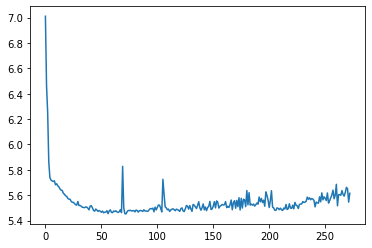

In [8]:
#Training process with verbose = 0. If you want to monitor the optimization process
# then change this parameter to 1.

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   min_delta=0,
                                   patience=200,
                                   verbose=0,
                                   mode='auto', 
                                   restore_best_weights=True)

model = build_UMAL(input_size=x_train.shape[-1],
                       learning_rate=1e-3,
                       architecture=hidden_architecture,
                       mu_act=lambda x: 1e-5 + K.softplus(x + 1e-5),
                       b_act=lambda x: 1e-5 + K.softplus(x + 1e-5))

K.set_value(model.n_taus, 100)
bs = 350

losshistory = model.fit(
    x_train,
    y_train,
    batch_size=bs,
    epochs=100000,
    initial_epoch=0,
    verbose=0,
    validation_data=[x_valid, y_valid],
    callbacks=[es])

#Show the validation loss epochs
plt.plot(losshistory.history['val_loss'])

## Results section

In [9]:
from tqdm import tqdm

model_pred = build_UMAL(**{**model._hp,'training':False})
model_pred.set_weights(model.get_weights())
sel_taus = np.arange(0.+5e-2,1.-5e-2,0.001)


bs = 100
pred_test = np.ones((sel_taus.shape[0],x_test.shape[0],int(model_pred.output.shape[-1])))*np.nan

# Predict for each input point the parameters of the selected conditioned ALDs 
#  identified by sel_taus
for i in tqdm(range(-((-x_test.shape[0])//bs))):
    pred_test[:,bs*i:bs*(i+1)] = sess.run(model_pred.output, 
                                          feed_dict={model_pred.input: x_test[bs*i:bs*(i+1)],
                                                     model_pred.taus:sel_taus}
                                         ).reshape(-1,len(sel_taus),model_pred.output.shape[-1]).transpose((1,0,2))
    
assert not np.sum(np.isfinite(pred_test)-1)

100%|██████████| 12/12 [00:00<00:00, 25.44it/s]


In [10]:
#Evaluate each ALD over all test points and calculates their corresponding predicted log-likelihood
dist_test, _, _, _ = calculate_distribution(pred_test, y_test[:, 0], epsilon=1e-3)

assert not np.sum(np.isfinite(dist_test)-1)

100%|██████████| 1150/1150 [00:00<00:00, 6456.77it/s]


In [11]:
#Calculate the Log-Likelihood of UMAL over all the test set

np.sum(np_log_sum_exp(dist_test,axis=-1).squeeze()-np.log(dist_test.shape[-1]))

-6253.642280935312